In [27]:
# Animation: circuitikz-style tree with auto layout, roomy leaves, single-hue gradient highlights,
# bold gradient "HierBOSSS" at the bottom (README-ready), and prominent highlight effects.
# Operators limited to {+, *, sin, /}. Saves to ~/Desktop/hierbosss_tree.gif (opens on macOS).
# Output: 300 DPI for crisp embedding in GitHub README.

import math, os, subprocess
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.patches import Circle, FancyArrowPatch, PathPatch
from matplotlib.textpath import TextPath
from matplotlib.transforms import Affine2D
from matplotlib.font_manager import FontProperties

# ---------------- Pacing (more frames) ----------------
INTRO_FRAMES = 12
HOLD_FRAMES_EACH = 8
OUTRO_FRAMES = 12
FPS = 10  # slower playback, clearer reading

# ---------------- Style ----------------
EDGE_COLOR = (76/255.0, 0/255.0, 255/255.0)        # outline / edge color (purple)
OP_FILL    = (211/255.0,195/255.0,249/255.0)      # operator fill (lavender)

# Single-hue gradient for highlighted terminals (light -> lavender)
GRAD_LIGHT = (245/255.0, 240/255.0, 255/255.0)
GRAD_DEEP  = OP_FILL

# Highlight glow color (soft purple halo)
GLOW_COLOR = (180/255.0, 160/255.0, 255/255.0)

# Base linewidth and radii/fonts
LINE_W         = 2.6
LINE_W_HI      = 3.6   # highlighted edges thicker
NODE_R         = 0.35  # slightly larger so labels fit comfortably
GLOW_EXTRA     = 0.10  # extra radius for glow ring

FONT_SIZE_OP   = 18
FONT_SIZE_LEAF = 18

# Bottom word styling (bolder fancy gradient)
ACC_FONT_SIZE = 54
ACC_OUTLINE_W = 10.0                 # thicker outline for boldness
ACC_GRAD1 = (170/255.0,  150/255.0, 245/255.0)  # darker purple
ACC_GRAD2 = (170/255.0,  150/255.0, 245/255.0)  # lighter purple
ACC_Y_AXES = 0.08                   # more separation from tree

# Layout spacing
Y_STEP       = 1.05
X_UNIT       = 1.08
X_PAD        = 0.52
MIN_LEAF_GAP = 2*NODE_R + 0.46      # roomy leaves (avoid overlap)

# ---------------- Tree ----------------
@dataclass
class Node:
    id: str
    label: str
    is_leaf: bool
    children: list

nodes = {
    "root":      Node("root",      "+",   False, ["u_sin_left", "op_right"]),
    # Left branch: sin -> * -> (+ H i, sin(+ e r))
    "u_sin_left":Node("u_sin_left","sin", False, ["mul"]),
    "mul":       Node("mul",       "*",   False, ["plus_hi", "u_sin_er"]),
    "plus_hi":   Node("plus_hi",   "+",   False, ["H", "i"]),
    "u_sin_er":  Node("u_sin_er",  "sin", False, ["plus_er"]),
    "plus_er":   Node("plus_er",   "+",   False, ["e", "r"]),
    # Right branch: "/" then sin then + for S's
    "op_right":  Node("op_right",  "/",   False, ["div_BO", "u_sin_S"]),
    "div_BO":    Node("div_BO",    "/",   False, ["B", "O"]),
    "u_sin_S":   Node("u_sin_S",   "sin", False, ["plus_S_SS"]),
    "plus_S_SS": Node("plus_S_SS", "+",   False, ["S1", "plus_SS"]),
    "plus_SS":   Node("plus_SS",   "+",   False, ["S2", "S3"]),
    # Leaves (features → spells HierBOSSS)
    "H":  Node("H",  "H", True, []),
    "i":  Node("i",  "i", True, []),
    "e":  Node("e",  "e", True, []),
    "r":  Node("r",  "r", True, []),
    "B":  Node("B",  "B", True, []),
    "O":  Node("O",  "O", True, []),
    "S1": Node("S1", "S", True, []),
    "S2": Node("S2", "S", True, []),
    "S3": Node("S3", "S", True, []),
}
leaf_order = ["H", "i", "e", "r", "B", "O", "S1", "S2", "S3"]
leaf_index = {lid: i for i, lid in enumerate(leaf_order)}  # robust indexing

# ---------------- Parent map & paths ----------------
parent_of = {}
for nid, nd in nodes.items():
    for c in nd.children:
        parent_of[c] = nid

def path_to_root(nid):
    p, cur = [], nid
    while cur in parent_of:
        p.append((parent_of[cur], cur))
        cur = parent_of[cur]
    return p

# ---------------- Auto layout ----------------
def leaf_count(nid):
    nd = nodes[nid]
    if nd.is_leaf or not nd.children: return 1
    return sum(leaf_count(c) for c in nd.children)

subtree_leaves = {nid: leaf_count(nid) for nid in nodes}

def depth(nid):
    d = 0
    while nid in parent_of:
        nid = parent_of[nid]; d += 1
    return d

levels = {nid: depth(nid) for nid in nodes}
max_level = max(levels.values())

pos = {}
def set_positions(nid, x_left, x_right, level):
    x = (x_left + x_right) / 2.0
    y = (max_level - level) * Y_STEP
    pos[nid] = (x, y)
    nd = nodes[nid]
    if not nd.children: return
    total = sum(subtree_leaves[c] for c in nd.children)
    cur_left = x_left
    for c in nd.children:
        w = (subtree_leaves[c] / total) * (x_right - x_left)
        set_positions(c, cur_left + X_PAD/2, cur_left + w - X_PAD/2, level + 1)
        cur_left += w

total_leaves = subtree_leaves["root"]
span = total_leaves * X_UNIT
set_positions("root", -span/2, span/2, 0)

# Enforce minimum gap between leaf centers (no overlap)
leaf_nodes = [nid for nid, nd in nodes.items() if nd.is_leaf]
leaf_nodes.sort(key=lambda n: pos[n][0])
xs = [pos[n][0] for n in leaf_nodes]
ys = [pos[n][1] for n in leaf_nodes]
mean_x = sum(xs) / len(xs)
total_width = (len(leaf_nodes)-1) * MIN_LEAF_GAP
start_x = mean_x - total_width / 2.0
new_xs = [start_x + i*MIN_LEAF_GAP for i in range(len(leaf_nodes))]
for n, nx in zip(leaf_nodes, new_xs):
    pos[n] = (nx, pos[n][1])

edges = [(nid, c) for nid, nd in nodes.items() for c in nd.children]
paths = [path_to_root(leaf) for leaf in leaf_order]

# ---------------- Gradient helpers ----------------
def draw_linear_gradient_circle(ax, x, y, r, c_top, c_bot, zorder=1, alpha=1.0):
    N = 128
    grad = np.linspace(0, 1, N).reshape(N, 1)
    rgb = np.zeros((N, 1, 3))
    for i in range(3):
        rgb[..., i] = c_top[i]*(1-grad) + c_bot[i]*grad
    im = ax.imshow(rgb, extent=(x-r, x+r, y-r, y+r), origin="lower",
                   zorder=zorder, alpha=alpha)
    circ_path = Circle((x, y), r)
    im.set_clip_path(circ_path)

def draw_gradient_text(ax, text, y_axes, fontsize_px, c1, c2):
    """
    Fancy gradient text centered at x=0.5 (axes coords), y=y_axes (axes coords).
    Uses outline + bold fallback to ensure visibility.
    """
    preferred = ["Copperplate", "Didot", "Snell Roundhand", "Brush Script MT", "Papyrus"]
    font_prop = FontProperties(family="DejaVu Sans")
    for fname in preferred:
        try:
            _ = TextPath((0, 0), "A", prop=FontProperties(family=fname))
            font_prop = FontProperties(family=fname, weight="bold")
            break
        except Exception:
            pass

    # Build text path in pixel-like units
    tp = TextPath((0, 0), text, size=fontsize_px, prop=font_prop, usetex=False)
    bb = tp.get_extents()
    width_px, height_px = bb.width, bb.height

    # Map px -> axes units (heuristic)
    px_to_ax = 0.12 / 100.0
    width_ax = width_px * px_to_ax
    height_ax = height_px * px_to_ax

    center_shift = Affine2D().translate(-width_px/2, 0)
    scale = Affine2D().scale(px_to_ax, px_to_ax)
    text_transform = scale + center_shift + ax.transAxes

    # Path patch (clip target)
    patch = PathPatch(tp, transform=text_transform, facecolor="none", edgecolor="none", zorder=6)
    ax.add_patch(patch)

    # Gradient rectangle sized to text width/height with a margin
    margin_x = 0.02
    margin_y_top = 0.035
    margin_y_bot = 0.013
    xmin, xmax = 0.5 - width_ax/2 - margin_x, 0.5 + width_ax/2 + margin_x
    ymin, ymax = y_axes - margin_y_bot, y_axes + height_ax + margin_y_top

    # Axes->Data conversion
    (x0, y0) = ax.transAxes.transform((xmin, ymin))
    (x1, y1) = ax.transAxes.transform((xmax, ymax))
    (xd0, yd0) = ax.transData.inverted().transform((x0, y0))
    (xd1, yd1) = ax.transData.inverted().transform((x1, y1))

    # Create vertical gradient and clip to text
    N = 256
    grad = np.linspace(0, 1, N).reshape(N, 1)
    rgb = np.zeros((N, 1, 3))
    for i in range(3):
        rgb[..., i] = c1[i]*(1-grad) + c2[i]*grad
    im = ax.imshow(rgb, extent=(xd0, xd1, yd0, yd1), origin="lower", zorder=5)
    im.set_clip_path(patch)

    # Bold fallback text (ensures visibility regardless of clipping)
    ax.text(0.5, y_axes, text, ha="center", va="baseline",
            transform=ax.transAxes, fontsize=int(fontsize_px*0.74),
            fontproperties=FontProperties(family=font_prop.get_name(), weight="bold"),
            color=c2, alpha=0.95, zorder=6)

    # Thick white outline on top for extra boldness
    outline = PathPatch(tp, transform=text_transform, facecolor="none",
                        edgecolor="white", linewidth=ACC_OUTLINE_W, zorder=7)
    ax.add_patch(outline)

# ---------------- Perimeter-edge helpers ----------------
def _shrink_to_circle(x1, y1, x2, y2, r):
    dx, dy = x2 - x1, y2 - y1
    L = math.hypot(dx, dy)
    if L == 0: return (x1, y1), (x2, y2)
    ux, uy = dx/L, dy/L
    return (x1 + ux*r, y1 + uy*r), (x2 - ux*r, y2 - uy*r)

def draw_edge(ax, u, v, highlight=False):
    x1, y1 = pos[u]; x2, y2 = pos[v]
    (sx, sy), (ex, ey) = _shrink_to_circle(x1, y1, x2, y2, NODE_R)
    seg = FancyArrowPatch(
        (sx, sy), (ex, ey),
        arrowstyle="-",
        linewidth=LINE_W_HI if highlight else LINE_W,
        color=EDGE_COLOR,
        mutation_scale=10,
        connectionstyle="arc3,rad=0.0",
        zorder=1
    )
    ax.add_patch(seg)

# ---------------- Draw nodes ----------------
def draw_operator(ax, nid, state="idle"):
    # state: "idle" or "path" or "current"
    x, y = pos[nid]
    # Glow ring for highlighted operator nodes
    if state != "idle":
        glow = Circle((x, y), radius=NODE_R + GLOW_EXTRA, linewidth=0,
                      facecolor=GLOW_COLOR, alpha=0.35, zorder=1.5)
        ax.add_patch(glow)
    circ = Circle((x, y), radius=NODE_R, linewidth=(LINE_W_HI if state != "idle" else LINE_W),
                  edgecolor=EDGE_COLOR, facecolor=OP_FILL, zorder=2)
    ax.add_patch(circ)
    ax.text(x, y, nodes[nid].label, ha="center", va="center",
            fontsize=FONT_SIZE_OP, fontweight=("bold" if state != "idle" else "normal"),
            color="black", zorder=3)

def draw_leaf(ax, nid, state="idle", pulse_phase=0.0):
    # state: 'idle' (hollow), 'done' (steady gradient), 'current' (pulsing gradient)
    x, y = pos[nid]
    # Glow ring for highlighted leaves
    if state in ("done", "current"):
        glow = Circle((x, y), radius=NODE_R + GLOW_EXTRA, linewidth=0,
                      facecolor=GLOW_COLOR, alpha=0.35, zorder=1.5)
        ax.add_patch(glow)
    # base circle
    base = Circle((x, y), radius=NODE_R,
                  linewidth=(LINE_W_HI if state in ("done", "current") else LINE_W),
                  edgecolor=EDGE_COLOR, facecolor="white", zorder=2)
    ax.add_patch(base)
    if state in ("done", "current"):
        if state == "done":
            ctop, cbot = GRAD_LIGHT, GRAD_DEEP
        else:
            t = 0.35 + 0.65 * (0.5 * (1 + math.cos(2*math.pi*pulse_phase)))
            ctop = tuple(GRAD_LIGHT[i]*(1-0.2*t) + GRAD_DEEP[i]*(0.2*t) for i in range(3))
            cbot = tuple(GRAD_LIGHT[i]*(1-0.6*t) + GRAD_DEEP[i]*(0.6*t) for i in range(3))
        draw_linear_gradient_circle(ax, x, y, NODE_R*0.985, ctop, cbot, zorder=2)
    ax.text(x, y, nodes[nid].label, ha="center", va="center",
            fontsize=FONT_SIZE_LEAF, color="black",
            fontweight="bold" if state in ("done", "current") else "normal",
            zorder=3)

# ---------------- Animation ----------------
fig, ax = plt.subplots(figsize=(12.0, 7.8), dpi=300)  # 300 DPI for crisp README rendering
fig.patch.set_facecolor("white")

frames = INTRO_FRAMES + len(leaf_order)*(1 + HOLD_FRAMES_EACH) + OUTRO_FRAMES

def animate(frame):
    ax.clear()
    xs = [p[0] for p in pos.values()]
    ys = [p[1] for p in pos.values()]
    xpad, ypad_top, ypad_bot = 1.0, 1.0, 2.4
    ax.set_xlim(min(xs)-xpad, max(xs)+xpad)
    ax.set_ylim(min(ys)-ypad_bot, max(ys)+ypad_top)
    ax.set_aspect('equal', adjustable='box')
    ax.axis("off")

    if frame < INTRO_FRAMES:
        k, local_hold = 0, 0
    else:
        f = frame - INTRO_FRAMES
        k = min(f // (1 + HOLD_FRAMES_EACH) + 1, len(leaf_order))
        local_hold = f % (1 + HOLD_FRAMES_EACH)

    # Which edges are on revealed paths?
    highlighted_edges = set()
    for i in range(k):
        for (u, v) in paths[i]:
            highlighted_edges.add((u, v))

    # Draw edges (highlight thicker where relevant)
    for (u, v) in edges:
        draw_edge(ax, u, v, highlight=((u, v) in highlighted_edges))

    # Operator states
    highlighted_nodes = {u for (u, v) in highlighted_edges} | {v for (u, v) in highlighted_edges}
    for nid, nd in nodes.items():
        if not nd.is_leaf:
            state = "path" if nid in highlighted_nodes else "idle"
            draw_operator(ax, nid, state=state)

    # Leaves
    for nid, nd in nodes.items():
        if nd.is_leaf:
            idx = leaf_index.get(nid, -1)
            if k == 0 or idx == -1 or idx >= k:
                draw_leaf(ax, nid, state="idle")
            elif idx < k-1:
                draw_leaf(ax, nid, state="done")
            else:
                phase = (local_hold / max(1, HOLD_FRAMES_EACH))
                draw_leaf(ax, nid, state="current", pulse_phase=phase)

    # Bottom fancy gradient word — only after at least one letter
    word = "".join(nodes[ch].label for ch in leaf_order[:k])
    if word:
        draw_gradient_text(ax, word, y_axes=ACC_Y_AXES,
                           fontsize_px=ACC_FONT_SIZE, c1=ACC_GRAD1, c2=ACC_GRAD2)

    # Title
    # ax.text(0.5, 0.986, "Bayesian SciML using Hierarchical Bayesian Operator-induced Symbolic Regression Trees for Structural Learning of Scientific Expressions",
    #         ha="center", va="center", fontsize=13, transform=ax.transAxes)
    return []

anim = animation.FuncAnimation(
    fig, animate, frames=frames, interval=1000.0/FPS, blit=False, save_count=frames
)

# ---------------- Save to Desktop (GIF, 300 DPI) & open (macOS) ----------------
save_dir = os.path.expanduser("~/Desktop")
os.makedirs(save_dir, exist_ok=True)
gif_path = os.path.join(save_dir, "hierbosss_tree.gif")

try:
    from matplotlib.animation import PillowWriter
    anim.save(gif_path, writer=PillowWriter(fps=FPS), dpi=300)  # <- 300 DPI
    print(f"Saved GIF to: {gif_path}")
    try:
        subprocess.run(["open", gif_path], check=False)
    except Exception:
        pass
except Exception as e:
    print("Failed to save GIF:", e)

plt.close(fig)

/var/folders/ls/s91_zt990n9b6gdbr57m19900000gn/T/ipykernel_26946/572051373.py:359: UserWarning: You passed in an explicit save_count=105 which is being ignored in favor of frames=105.
  anim = animation.FuncAnimation(


Saved GIF to: /Users/somjit/Desktop/hierbosss_tree.gif


In [19]:
# Draw a symbolic expression as a tree (static figure)
# ---------------------------------------------------
# - Input: a string expression (Python-like), e.g. "5*(x1 + x2)*x3 + epsilon"
# - Supported operators: +, -, *, /, ** (or ^), unary -/+
# - Supported functions: sin, cos, tan, exp, log, sqrt, abs  (extendable)
# - Variables/constants: names like x, x1, y, epsilon; numeric literals
# - Notes:
#     • Use explicit multiplication (*) — e.g., 5*(x1+x2)*x3 (not 5(x1+x2)x3)
#     • You may write "^" for power; it will be converted to "**"
#
# Styling:
# - Operator nodes: lavender fill, purple outline
# - Leaf nodes: white fill, purple outline
# - Edges: thin black lines
#
# Usage:
#   draw_symbolic_tree("5*(x1 + x2)*x3 + epsilon", filename="tree.png", dpi=300)

import ast
import math
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyArrowPatch

# ---------------- Style ----------------
EDGE_COLOR_NODE = (76/255.0, 0/255.0, 255/255.0)   # node outline (purple)
OP_FILL         = (211/255.0,195/255.0,249/255.0)  # operator fill (lavender)

LINE_W_NODE = 2.0
LINE_W_EDGE = 1.2
NODE_R      = 0.33

FONT_SIZE_OP   = 14
FONT_SIZE_LEAF = 13

# Layout spacing
Y_STEP       = 1.05
X_UNIT       = 1.05
X_PAD        = 0.50
MIN_LEAF_GAP = 2*NODE_R + 0.40

ALLOWED_FUNCS = {"sin", "cos", "tan", "exp", "log", "sqrt", "abs"}

@dataclass
class TNode:
    label: str
    children: list  # list[TNode]
    is_leaf: bool

# ---------------- Parsing: expression string -> tree ----------------
def _normalize_expr(expr: str) -> str:
    """Basic normalization: replace '^' with '**'; strip surrounding spaces."""
    expr = expr.strip()
    # Replace caret power with Python power
    expr = expr.replace("^", "**")
    return expr

def _ast_to_tree(node) -> TNode:
    if isinstance(node, ast.BinOp):
        op = node.op
        if   isinstance(op, ast.Add): sym = "+"
        elif isinstance(op, ast.Sub): sym = "−"  # unicode minus for visual distinction
        elif isinstance(op, ast.Mult): sym = "×"
        elif isinstance(op, ast.Div): sym = "÷"
        elif isinstance(op, ast.Pow): sym = "^"
        else:
            raise ValueError(f"Unsupported binary operator: {type(op).__name__}")
        return TNode(sym, [ _ast_to_tree(node.left), _ast_to_tree(node.right) ], is_leaf=False)

    if isinstance(node, ast.UnaryOp):
        if isinstance(node.op, ast.USub):
            return TNode("neg", [ _ast_to_tree(node.operand) ], is_leaf=False)
        if isinstance(node.op, ast.UAdd):
            return TNode("pos", [ _ast_to_tree(node.operand) ], is_leaf=False)
        raise ValueError(f"Unsupported unary operator: {type(node.op).__name__}")

    if isinstance(node, ast.Call):
        # function name
        if isinstance(node.func, ast.Name):
            fname = node.func.id
        else:
            raise ValueError("Only simple function calls like sin(x) are supported.")
        if fname not in ALLOWED_FUNCS:
            raise ValueError(f"Function '{fname}' not in allowed set {sorted(ALLOWED_FUNCS)}.")
        return TNode(fname, [ _ast_to_tree(arg) for arg in node.args ], is_leaf=False)

    if isinstance(node, ast.Name):
        return TNode(node.id, [], is_leaf=True)

    if isinstance(node, ast.Constant):
        return TNode(str(node.value), [], is_leaf=True)

    # Parentheses are implicit in AST structure; also handle expressions
    if isinstance(node, ast.Expr):
        return _ast_to_tree(node.value)

    raise ValueError(f"Unsupported AST node: {type(node).__name__}")

def parse_expression_to_tree(expr: str) -> TNode:
    code = _normalize_expr(expr)
    tree = ast.parse(code, mode="eval")
    return _ast_to_tree(tree.body)

# ---------------- Layout: compute positions ----------------
def _leaf_count(nd: TNode) -> int:
    if nd.is_leaf or not nd.children:
        return 1
    return sum(_leaf_count(c) for c in nd.children)

def _assign_positions(nd: TNode, x_left: float, x_right: float, level: int, pos: dict, max_level: int):
    x = (x_left + x_right) / 2.0
    y = (max_level - level) * Y_STEP
    pos[id(nd)] = (x, y)
    if nd.is_leaf or not nd.children:
        return
    total = sum(_leaf_count(c) for c in nd.children)
    cur_left = x_left
    for c in nd.children:
        w = (_leaf_count(c) / total) * (x_right - x_left)
        _assign_positions(c, cur_left + X_PAD/2, cur_left + w - X_PAD/2, level+1, pos, max_level)
        cur_left += w

def _collect_nodes_edges(nd: TNode):
    nodes = []
    edges = []
    def dfs(u: TNode):
        nodes.append(u)
        for v in u.children:
            edges.append((u, v))
            dfs(v)
    dfs(nd)
    return nodes, edges

def _max_depth(nd: TNode) -> int:
    if nd.is_leaf or not nd.children:
        return 0
    return 1 + max(_max_depth(c) for c in nd.children)

def _enforce_leaf_spacing(root: TNode, pos: dict):
    # collect leaves
    leaves = []
    def dfs(u: TNode):
        if u.is_leaf or not u.children:
            leaves.append(u)
        else:
            for v in u.children:
                dfs(v)
    dfs(root)
    # sort by x
    leaves.sort(key=lambda u: pos[id(u)][0])
    xs = [pos[id(u)][0] for u in leaves]
    if not xs:
        return
    mean_x = sum(xs) / len(xs)
    total_width = (len(leaves)-1) * MIN_LEAF_GAP if len(leaves) > 1 else 0
    start_x = mean_x - total_width / 2.0
    new_xs = [start_x + i*MIN_LEAF_GAP for i in range(len(leaves))]
    for u, nx in zip(leaves, new_xs):
        x_old, y_old = pos[id(u)]
        pos[id(u)] = (nx, y_old)

# ---------------- Drawing ----------------
def _shrink_to_circle(x1, y1, x2, y2, r):
    dx, dy = x2 - x1, y2 - y1
    L = math.hypot(dx, dy)
    if L == 0: return (x1, y1), (x2, y2)
    ux, uy = dx/L, dy/L
    return (x1 + ux*r, y1 + uy*r), (x2 - ux*r, y2 - uy*r)

def _draw_edge(ax, pos, u: TNode, v: TNode):
    x1, y1 = pos[id(u)]; x2, y2 = pos[id(v)]
    (sx, sy), (ex, ey) = _shrink_to_circle(x1, y1, x2, y2, NODE_R)
    seg = FancyArrowPatch(
        (sx, sy), (ex, ey), arrowstyle="-",
        linewidth=LINE_W_EDGE, color="black",
        mutation_scale=8, connectionstyle="arc3,rad=0.0", zorder=1
    )
    ax.add_patch(seg)

def _draw_operator(ax, nd: TNode, pos, highlight=False):
    x, y = pos[id(nd)]
    circ = Circle((x, y), radius=NODE_R,
                  linewidth=LINE_W_NODE + (0.8 if highlight else 0.0),
                  edgecolor=EDGE_COLOR_NODE, facecolor=OP_FILL, zorder=2)
    ax.add_patch(circ)
    ax.text(x, y, nd.label, ha="center", va="center",
            fontsize=FONT_SIZE_OP, fontweight=("bold" if highlight else "normal"),
            color="black", zorder=3)

def _draw_leaf(ax, nd: TNode, pos):
    x, y = pos[id(nd)]
    base = Circle((x, y), radius=NODE_R, linewidth=LINE_W_NODE,
                  edgecolor=EDGE_COLOR_NODE, facecolor="white", zorder=2)
    ax.add_patch(base)
    ax.text(x, y, nd.label, ha="center", va="center",
            fontsize=FONT_SIZE_LEAF, color="black", zorder=3)

# ---------------- Public API ----------------
def draw_symbolic_tree(expr: str, filename: str = None, figsize=(10, 6), dpi=200, show=True):
    """
    Draw a symbolic expression as a tree.

    Parameters
    ----------
    expr : str
        Python-like expression string. Examples:
          "5*(x1 + x2)*x3 + epsilon"
          "sin(x) + cos(y/2) - log(z**2)"
          "sqrt(x1*x2) + (x3 - 3)/abs(x4)"
          "exp(-(x**2 + y**2))"
        Use explicit '*' for multiplication. '^' is allowed and converted to '**'.
    filename : str or None
        If provided, saves the figure to this path (e.g., 'tree.png' or 'tree.pdf').
    figsize : tuple(float, float)
        Figure size in inches.
    dpi : int
        Figure DPI.
    show : bool
        If True, calls plt.show().

    Returns
    -------
    fig, ax : matplotlib Figure and Axes
    """
    root = parse_expression_to_tree(expr)

    # Layout positions
    max_level = _max_depth(root)
    total_leaves = _leaf_count(root)
    span = max(1, total_leaves) * X_UNIT

    pos = {}
    _assign_positions(root, -span/2, span/2, 0, pos, max_level)
    _enforce_leaf_spacing(root, pos)

    # Collect nodes/edges for drawing and axis limits
    nodes, edges = _collect_nodes_edges(root)
    xs = [pos[id(n)][0] for n in nodes]
    ys = [pos[id(n)][1] for n in nodes]

    # Figure
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    fig.patch.set_facecolor("white")
    xpad, ypad_top, ypad_bot = 1.0, 1.0, 1.4
    ax.set_xlim(min(xs)-xpad, max(xs)+xpad)
    ax.set_ylim(min(ys)-ypad_bot, max(ys)+ypad_top)
    ax.set_aspect('equal', adjustable='box')
    ax.axis("off")

    # Draw edges
    for (u, v) in edges:
        _draw_edge(ax, pos, u, v)

    # Draw nodes (highlight root)
    for n in nodes:
        if n.children:
            _draw_operator(ax, n, pos, highlight=(n is root))
        else:
            _draw_leaf(ax, n, pos)

    if filename:
        fig.savefig(filename, bbox_inches="tight", pad_inches=0.05)
    if show:
        plt.show()
    return fig, ax


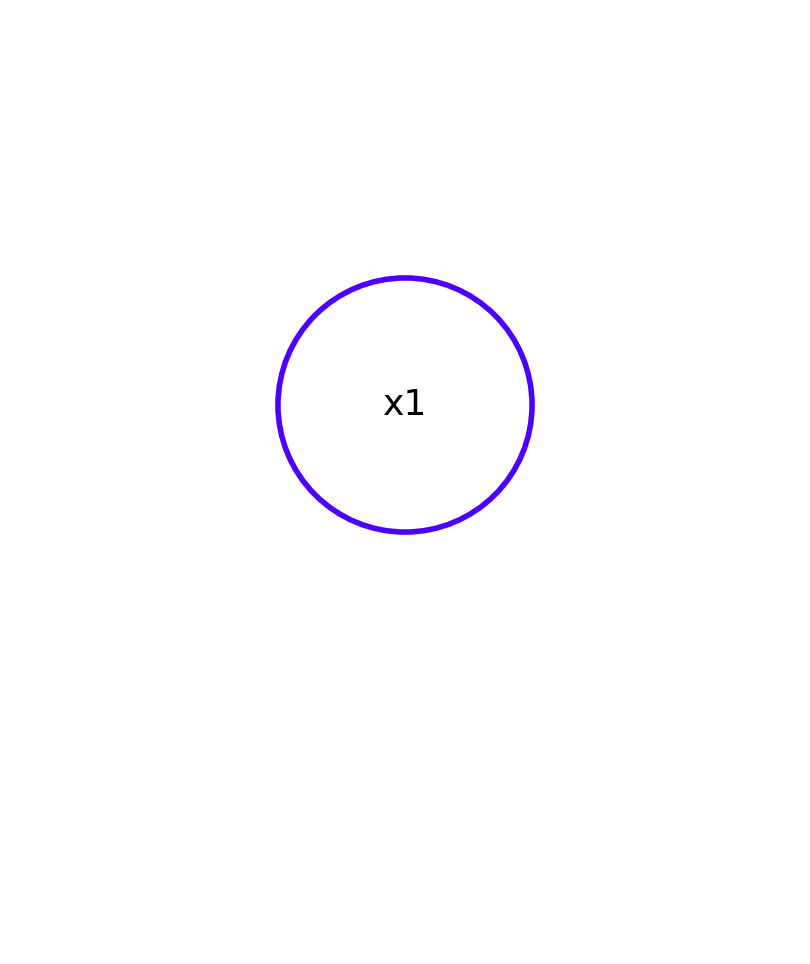

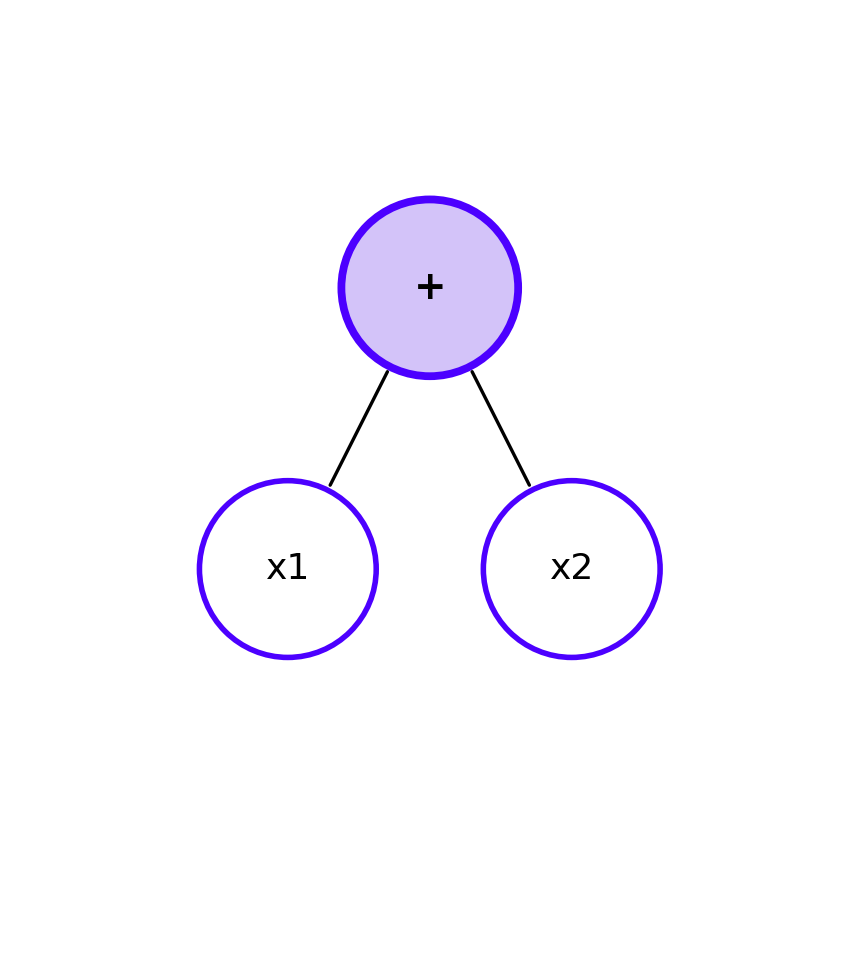

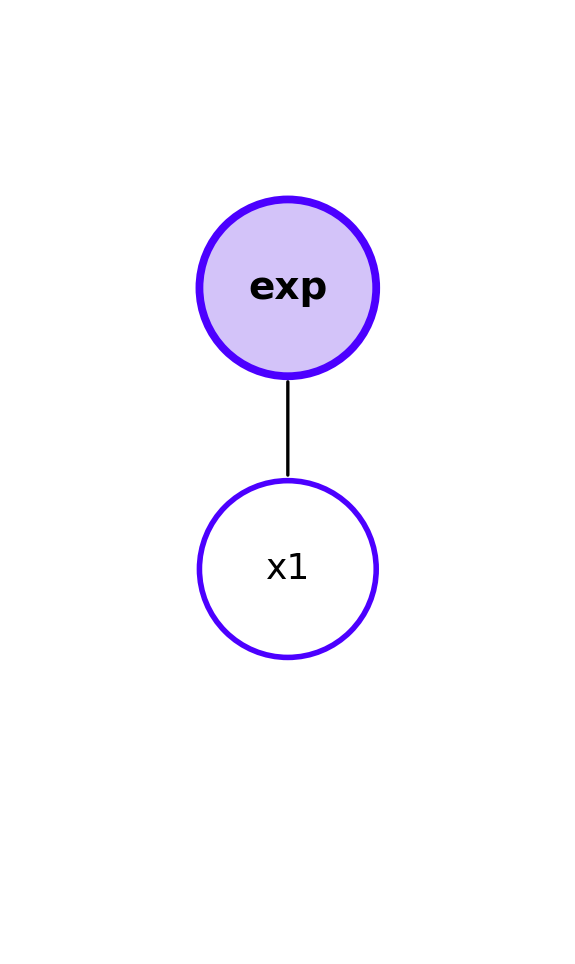

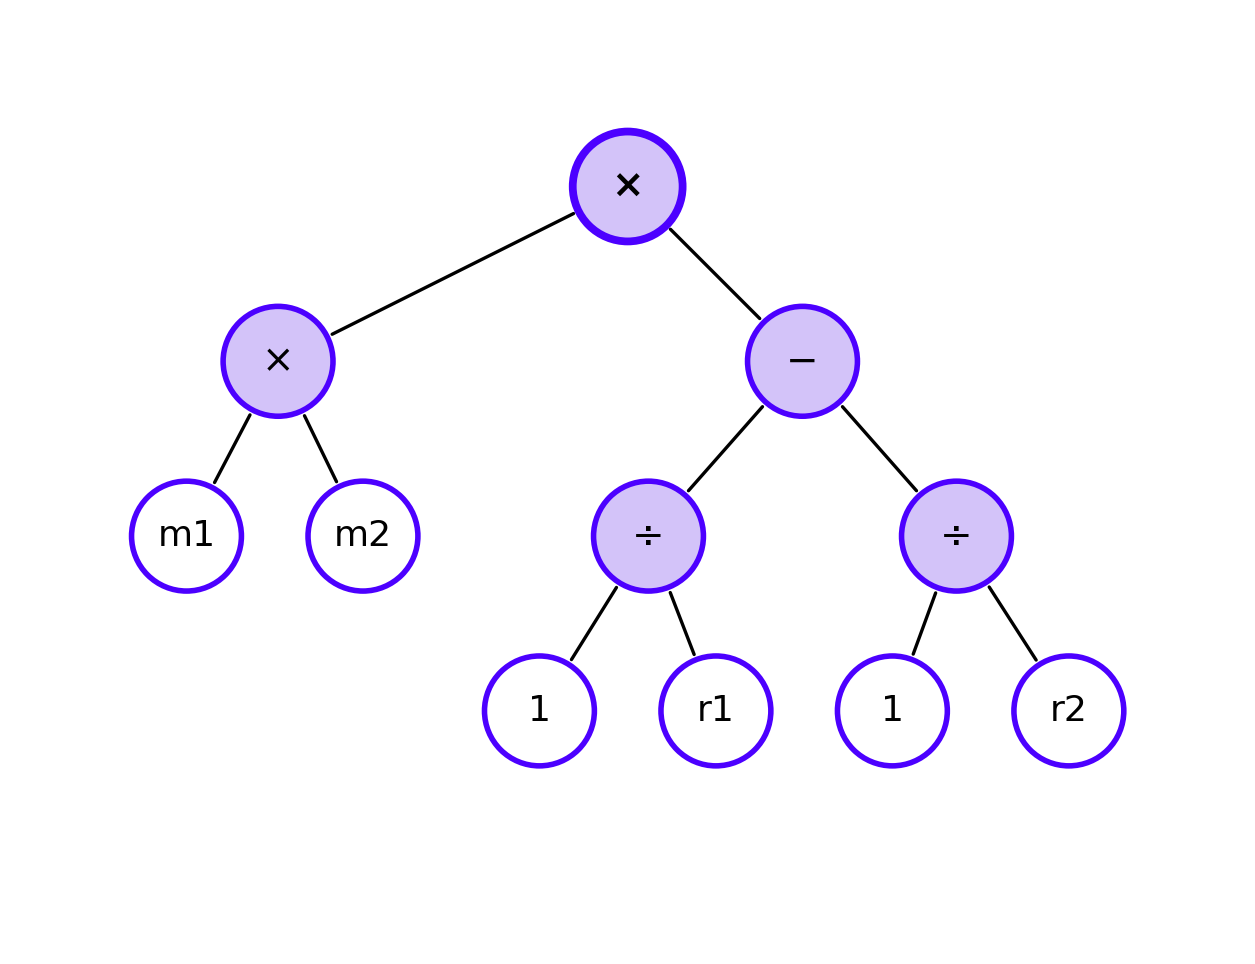

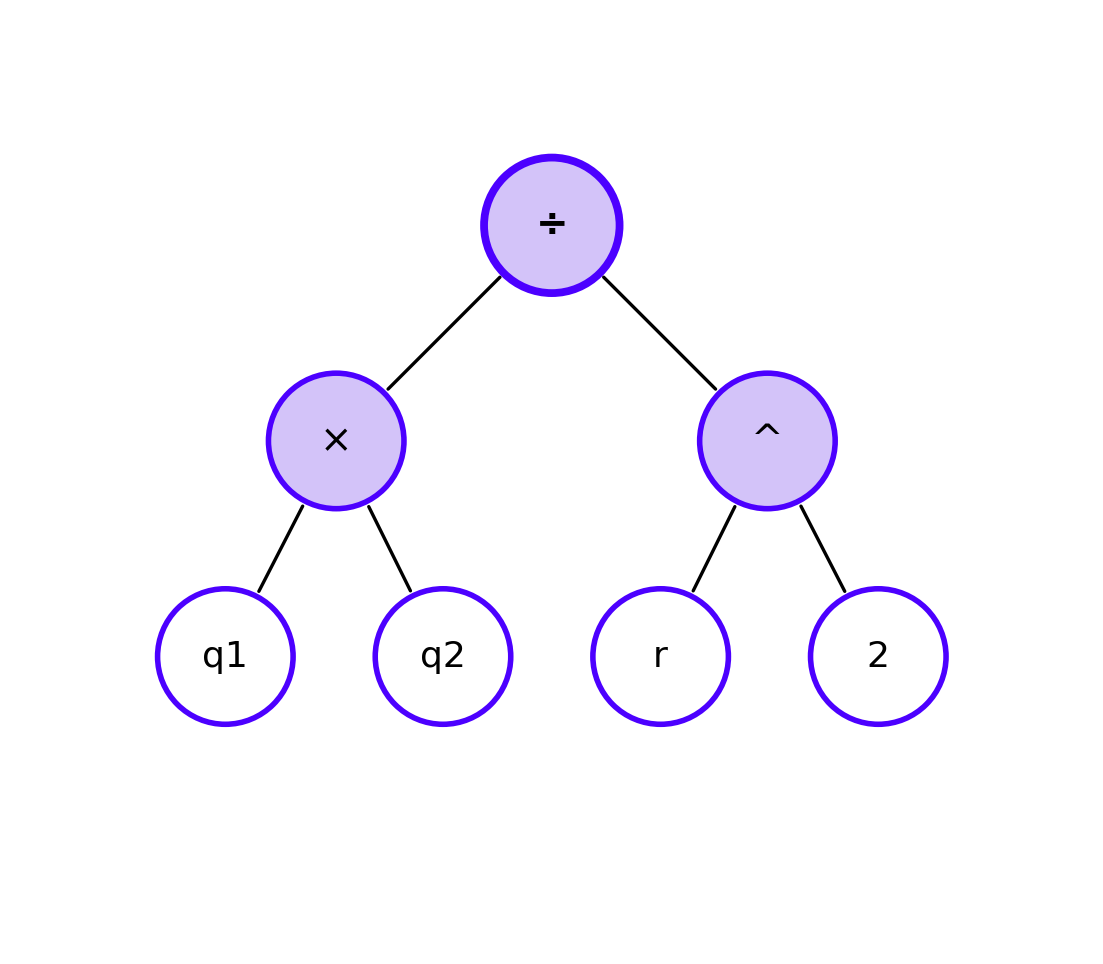

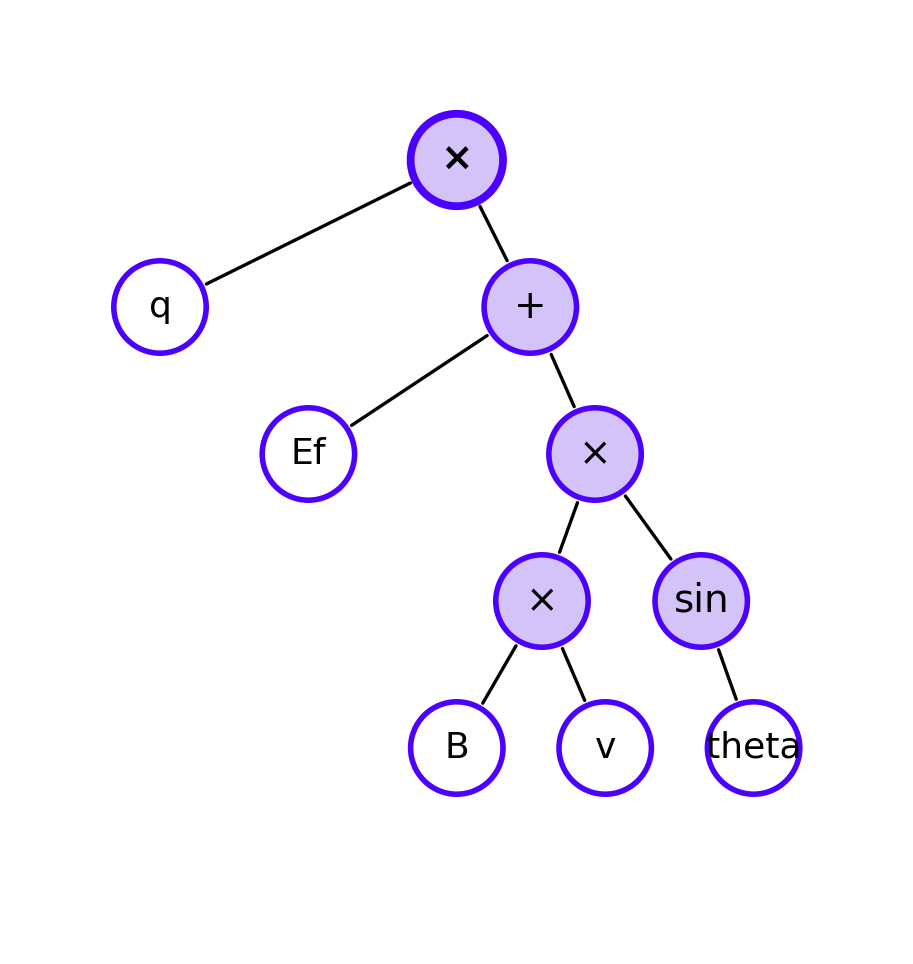

In [20]:
# ---------------- Examples ----------------
if __name__ == "__main__":
    # x1
    draw_symbolic_tree("x1", filename="assets/x1.png", show=True)
    
    # x1 + x2
    draw_symbolic_tree("x1 + x2", filename="assets/x1_plus_x2.png", show=True)
    
    # exp(x1)
    draw_symbolic_tree("exp(x1)", filename="assets/exp_x1.png", show=True)
    
    # GPE
    draw_symbolic_tree("m1 * m2 * (1/r1 - 1/r2)", filename="assets/GPE.png", show=True)
    
    # Coulomb's Law
    draw_symbolic_tree("(q1*q2)/r^2", filename="assets/Coulomb.png", show=True)
    
    # Lorentz Force
    draw_symbolic_tree("q * (Ef + B * v * sin(theta))", filename="assets/Lorentz.png", show=True)